In [2]:
import os
from pyspark.sql import DataFrame
from graphframes import GraphFrame
from pyspark.shell import spark
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.11.6 (main, Oct  3 2023 11:57:02)
Spark context Web UI available at http://a631c2750154:4040
Spark context available as 'sc' (master = local[*], app id = local-1736459713269).
SparkSession available as 'spark'.


### 1
Load the Facebook graph, edges from the musae_facebook_edges.csv file, page_name and page_type attributes from the musae_facebook_target.csv file.  Count the number of edges and vertices. (1 p.)

In [3]:
file_location_edges = "facebook_large/musae_facebook_edges.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

edges = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location_edges)

display(edges)

DataFrame[id_1: string, id_2: string]

In [4]:
file_location_target = "facebook_large/musae_facebook_target.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

vertices = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location_target)\
    .select("id", "page_name", "page_type") # page_name, page_type

display(vertices)

DataFrame[id: string, page_name: string, page_type: string]

In [5]:
sc = spark.builder.appName("FacebookGraph").getOrCreate()

In [6]:
edges = edges.withColumnRenamed("id_1", "src").withColumnRenamed("id_2", "dst")

In [7]:
graph = GraphFrame(vertices, edges)

In [8]:
num_edges = graph.edges.count()
num_vertices = graph.vertices.count()

print(f"Number of edges: {num_edges}")
print(f"Number of vertices: {num_vertices}")

Number of edges: 171002
Number of vertices: 22470


### 2
Check that the graph is consistent. Are the two subgraphs formed for the page types governmental organisations and television shows also consistent? (1 p.)

In [9]:
# create context checkpoint
checkpoint_dir = "./my_checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)
spark.sparkContext.setCheckpointDir(checkpoint_dir)

In [10]:
is_connected = graph.connectedComponents().select("component").distinct().count()
is_connected == 1 # graph connectivity

True

In [11]:
g_gov = graph.filterVertices("page_type == 'government'")
is_connected_subgraphs_gov = g_gov.connectedComponents().select("component").distinct().count()
is_connected_subgraphs_gov == 1

False

In [12]:
g_tv = graph.filterVertices("page_type == 'tvshow'")
is_connected_subgraphs_tv = g_tv.connectedComponents().select('component').distinct().count()
is_connected_subgraphs_tv == 1

False

### 3
Of the 1,000 pages with the highest PageRank, find 50 such pages (list page_name and page_type) that have the fewest connections and 50 with the most connections. Which page type was dominant in each of these categories? Draw a graph of the dependence of PageRank on the number of edges for vertices (scatter plot) (2 p.)

In [13]:
results = graph.pageRank(resetProbability=0.15, tol=0.01)
rankedVertexDegrees = results.vertices.join(graph.outDegrees, 'id')
display(rankedVertexDegrees)

DataFrame[id: string, page_name: string, page_type: string, pagerank: double, outDegree: int]

In [14]:
top_1000 = rankedVertexDegrees.orderBy("pagerank", ascending=False).limit(1000)
top_50 = top_1000.orderBy(F.desc("outDegree")).limit(50)
bottom_50 = top_1000.orderBy(F.asc("outDegree")).limit(50)

In [15]:
print(top_1000.show(5))
print(top_50.show(5))
print(bottom_50.show(5))

+-----+--------------------+----------+------------------+---------+
|   id|           page_name| page_type|          pagerank|outDegree|
+-----+--------------------+----------+------------------+---------+
|21729|The Obama White H...|government|117.55736999319167|       16|
|21781|           Microsoft|   company|55.797610617868585|        1|
|22329|               NHTSA|government|46.512349673665334|        1|
|20415|    Joachim Herrmann|politician|42.326554427294894|       39|
|21955|             Digicel|   company|  35.9891242246724|        2|
+-----+--------------------+----------+------------------+---------+
only showing top 5 rows

None
+-----+--------------------+----------+------------------+---------+
|   id|           page_name| page_type|          pagerank|outDegree|
+-----+--------------------+----------+------------------+---------+
| 8883|    U.S. Coast Guard|government|2.6707799488884216|      226|
|14497|U.S. Army Chaplai...|government|16.067926524867612|      220|
| 93

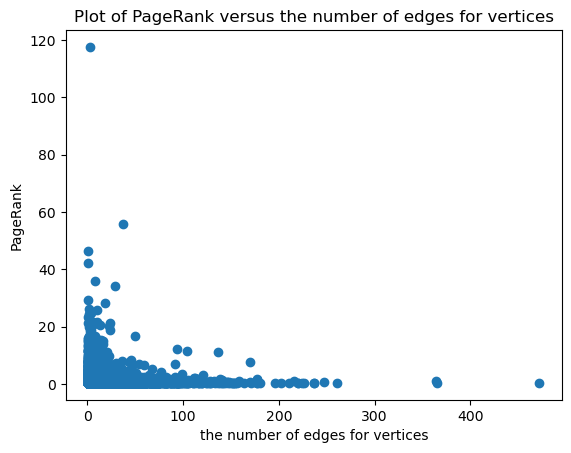

In [16]:
x_ranks_degree = rankedVertexDegrees.select("outDegree").collect()
y_ranks_degree = rankedVertexDegrees.select("pagerank").collect()

plt.scatter(x_ranks_degree, y_ranks_degree)
plt.title("Plot of PageRank vs number of edges for vertices")
plt.xlabel('number of edges for vertices')
plt.ylabel('PageRank')
plt.show()

### 4
Using the Pregel API, implement the following algorithm. In the first step, a selected party publishes a fake news post. In the next step, this post is published by 1/4 of the randomly selected contacts of this page. In further steps, for each page that has already published this post, a randomly selected 1/4 of its contacts publish it. Show how the number of parties who have published the post changes as a function of the number of steps. (2 p.)
Optional: Check the above relationship for a ratio other than 1/4.

### 5
Draw a graph of the degree distribution of vertices in the graph on a logarithmic scale. You can use the stat.approxQuantile method. Is the network scale-free? https://barabasi.com/f/623.pdf (2 p.)

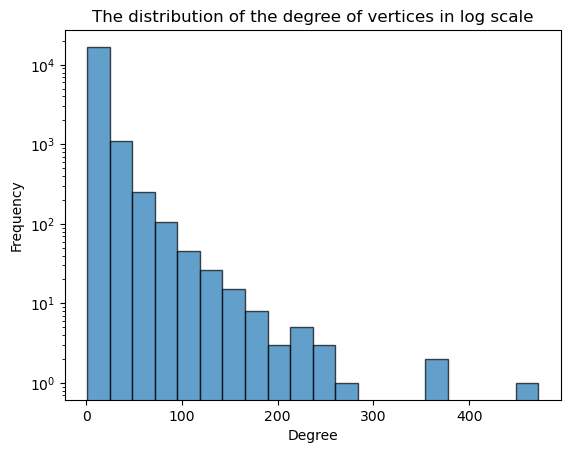

In [17]:
degrees = graph.outDegrees.select("outDegree").rdd.flatMap(lambda x: x).collect()

plt.hist(degrees, 20, log=True, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Distribution of the degree of vertices in log scale')
plt.show()

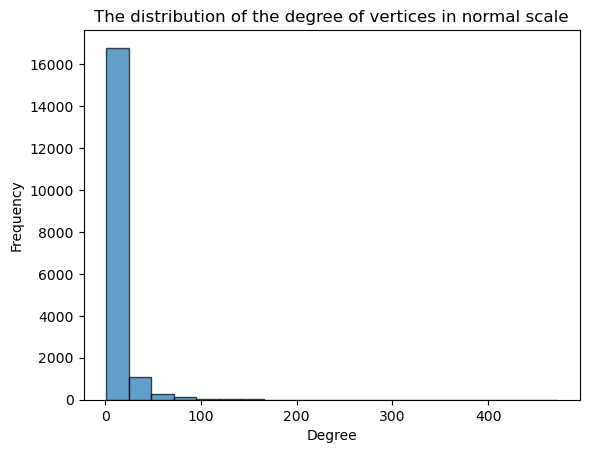

In [18]:
degrees = graph.outDegrees.select("outDegree").rdd.flatMap(lambda x: x).collect()

plt.hist(degrees, 20, edgecolor='black', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Distribution of the degree of vertices in normal scale')
plt.show()